In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import gym

from tensorflow import keras
np.random.seed(0)
tf.random.set_seed(0)
%matplotlib notebook

class Chart:
    def __init__(self):
        self.fig, self.ax = plt.subplots(1, 1)
    
    def plot(self, episode_rewards):
        self.ax.clear()
        self.ax.plot(episode_rewards)
        self.ax.set_xlabel('iteration')
        self.ax.set_ylabel('episode reward')
        self.fig.canvas.draw()

# 第九章 连续动作空间的确定性策略

In [2]:
env = gym.make('Pendulum-v0')
env.seed(0)

[0]

## 同策确定性算法

对于连续空间里的确定性策略，$\pi(a|s;\theta)$并不是一个同常意义上的函数。它对策略参数$\theta$的梯度$\nabla\pi(a|s;\theta)$也不复存在。由此上一章的执行者/评论者方法也就不再适用。第二章提到过，确定性策略可以表示为$\pi(s;\theta)$。这种表示可以绕过由于$\pi(a|s;\theta)$不是通常意义上的函数而带来的困难。

本节介绍连续空间中的确定性策略梯度定理，并据此给出基本的同策确定性执行者/评论者算法。

### 策略梯度定理的确定性版本

当策略是一个连续动作空间上的确定性策略$\pi(s;\theta)$，策略梯度定理为：
$$
\nabla E_{\pi(\theta)}[G_0] = E \left[ \sum_{t=0}^{+\infty}\gamma^t\nabla\pi(S_t;\theta)[\nabla_a q_{\pi(\theta)}(S_t,a)]_{a = \pi(S_t;\theta)} \right]
$$
证明略。

对于连续空间中的确定性策略，更常使用的是另一种形式：
$$
\nabla E_{\pi(\theta)}[G_0] = E_{S\sim \rho_\pi(\theta)}\left[ \nabla\pi(S;\theta) [\nabla_a q_{\pi(\theta)}(S_t,a)]_{a = \pi(S_t;\theta)} \right]
$$
其中的期望是针对折扣的状态分布
$$
\rho_\pi(s) = \int_{s_0 \in S}p_{s_0}(s_0) \sum_{t=0}^{+\infty}\gamma^t \Pr[S_t = s|S_0 = s_0;\theta]\mathrm{d}s_0
$$
而言的。证明略。

### 基本的同策确定性执行者/评论者算法

据策略梯度定理的确定性版本，对于连续动作空间中的确定性执行者/评论者算法，梯度的方向变为
$$
E \left[ \sum_{t=0}^{+\infty}\gamma^t\nabla\pi(S_t;\theta)[\nabla_a q_{\pi(\theta)}(S_t,a)]_{a = \pi(S_t;\theta)} \right]
$$
确定性的同策执行者/评论者算法还是用$q(s,a;w)$来近似$q_{\pi(\theta)}(s,a;w)$。这时，$\gamma^t\nabla\pi(S_t;\theta)[\nabla_a q_{\pi(\theta)}(S_t,a)]_{a = \pi(S_t;\theta)}$近似为：
$$
\gamma^t\nabla\pi(S_t;\theta)[\nabla_a q_{\pi(\theta)}(S_t,a)]_{a = \pi(S_t;\theta)}  = \nabla_\theta [\gamma^t q(S_t,\pi(S_t;\theta);w)]
$$
所以与随机版本的同策执行者/评论者算法相比，确定性同策执行者/评论者算法在更新策略参数$\theta$时试图减小$-\gamma^tq(S_t,\pi(S_t;\theta);w)$。迭代式可以是
$$
\theta \leftarrow \theta +\gamma^t\nabla\pi(S_t;\theta)[\nabla_a q_{\pi(\theta)}(S_t,a)]_{a = \pi(S_t;\theta)}
$$
对于同策算法啊，必须进行探索。连续性动作空间的确定性算法将每个状态都映射到一个确定的动作上，需要在动作空间添加扰动实现探索。

具体而言，在状态$S_t$下确定性策略$\pi(\theta)$指定的动作为$\pi(S_t;\theta)$，则在同策算法中使用的动作可以具有$\pi(S_t;\theta) + N_t$的形式，其中$N_t$是扰动量。在动作空间无界的情况下（没有限制动作有最大最小值），常常假设扰动量$N_t$满足高斯分布。在动作空间有界的情况下，可以用clip函数进一步限制加扰动后的范围（如$\mathrm{clip}(\pi(S_t;\theta) +N_t, A_{low},A_{high})$），其中$A_{low}$和$A_{high}$是动作的最小取值和最大取值，或用sigmoid函数将对加扰动后的动作变换到合适区间里（如$A_{low} +(A_{high} - A_{low})\mathrm{expit}(\pi(S_t;\theta) +N_t)$）

#### 具体实现

【输入】环境（无数学描述）

【输出】最优策略的估计$\pi(\theta)$

【参数】学习率$\alpha^{(w)},~\alpha^{(\theta)}$，折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：$\theta \leftarrow any,~w \leftarrow any$
2. 带自益的策略更新：对每个回合执行以下操作：
   1. 初始化累积折扣：$I \leftarrow 1$
   2. 初始化状态动作对：选择动作$S$，对$\pi(S;\theta)$加扰动进而确定动作$A$（如用正态分布随机变量扰动）
   3. 如果回合未结束，执行以下操作：
      1. 采样：根据状态$S$和动作$A$得到采样$R$和下一状态$S'$
      2. 执行：对$\pi(S';\theta)$加扰动进而确定动作$A'$
      3. 估计回报：$U \leftarrow R +\gamma q(S',A';w)$
      4. 更新价值：更新$w$以减小$[U - q(S,A;w)]^2$（如$w \leftarrow w + \alpha^{(w)}[U - q(S,A;w)]\nabla q(S,A;w)$）
      5. 策略改进：更新$\theta$以减小$-Iq(S,\pi(S;\theta);w)$（如$\theta \leftarrow \theta + \alpha^{(\theta)}I\nabla\pi(S;\theta)[\nabla_aq(S,a;w)]$）
      6. 更新累积折扣：$I \leftarrow \gamma I$
      7. 更新状态$S \leftarrow S', A \leftarrow A'$

有些任务中，动作的效果经过低通滤波器处理后反映在系统中，而独立同分布的Gaussian噪音不能有效实现探索。

> 例如，在某个任务中，动作的直接效果是改变一个质点的加速度，若在此任务中独立同分布的Gaussian噪音叠加在动作上，那么对质点位置的整体效果是在没有噪声的位置附近移动。这样探索就无法为质点的位置提供持续偏移，使质点到较远位置。

在上述任务中，常常用Ornstein Uhlenbeck过程作为动作噪声。Ornstein Uhlenbeck过程是用如下的随机微分方程定义的（以一维情况为例）：
$$
\mathrm{d}N_t = \theta(\mu - N_t)\mathrm{d}t + \sigma \mathrm{d}B_t
$$
其中$\theta, \mu, \sigma$是参数，$B_t$是标准Brownian运动。当初始扰动是在原点的单点分布（即限定$N_0 = 0$），且$\mu = 0$时上述方程的解为：
$$
N_t = \sigma \int_0^te^{\theta(\tau - t)}\mathrm{d}B_t
$$
这个解的均值为0，方差为$\frac{\sigma^2}{2\theta}(1 - e^{-2\theta t})$，协方差为$\mathrm{Cov}(N_t,N_s) = \frac{\sigma^2}{2\theta}(e^{-\theta|t-s|} - e^{-\theta (t+s)})$

（证明略）

对于$t \ne s$总有$|t - s| < t+s$，所以$\mathrm{Cov}(N_t, N_s) > 0$。由此可知，Ornstein Uhlenbeck过程过程让相邻的扰动正相关，进而让动作向相近的方向偏移。


## 异策确定性算法

对于连续的动作空间，我们希望能够找到一个确定性策略，使得每条轨迹的回报最大。同策确定性算法利用策略$\pi(\theta)$生成轨迹，并在这些轨迹上求得回报的平均值，通过让平均回报最大，使得每条轨迹上的回报尽可能大。事实上，如果每条轨迹回报都要最大，那么对于任意策略$b$采样得到的轨迹，我们都希望在这套轨迹上的平均回报最大。所以异策确定性策略算法引入确定性行为$b$，将这个平均改为针对$b$采样得到的策略，得到异策确定性梯度为：
$$
\nabla E_{\rho_b}[q_{\pi(\theta)}(S,\pi(S;\theta))] = E_{\rho_b}\left[ \nabla\pi(S;\theta)[\nabla_aq_{\pi(\theta)}(S,a)]_{a = \pi(S;\theta)} \right]
$$
这个表达式与同策情形相比，期望运算针对的表达式相同。所以异策确定性算法的迭代式与同策确定性算法的迭代式相同。

异策确定性算法可能比同策确定性算法性能好的原因在于：行为策略可能会促进探索，用行为策略采样得到的轨迹能够更加全面的探索轨迹空间。这时候，最大化对轨迹分布的平均期望时能同时考虑到不同的轨迹，使得在整个轨迹空间上的所有轨迹的回报会更大。

### 基本的异策确定性执行者/评论者算法

虽然异策算法和同策算法有相同形式的迭代式，但在算法结构上不完全相同。

* 同策算法迭代更新时，目标策略的动作可以在运行过程中直接得到
* 异策算法迭代更新策略参数时，对环境使用的是行为策略决定的动作，所以需要额外计算目标策略的动作。

在更新价值函数时，采用的Q学习，依然需要计算目标策略的动作。

#### 算法实现

【输入】环境（无数学描述）

【输出】最优策略的估计$\pi(\theta)$

【参数】学习率$\alpha^{(w)},~\alpha^{(\theta)}$，折扣因子$\gamma$，控制回合数和回合内步数的参数

1. 初始化：$\theta \leftarrow any,~w \leftarrow any$
2. 带自益的策略更新：对每个回合执行以下操作：
   1. 初始化累积折扣：$I \leftarrow 1$
   2. 初始化状态动作对：选择状态$S$
   3. 若回合未结束执行以下操作：
      1. 执行：用$b(·|S)$确定动作$A$
      2. 采样：用状态$S$和动作$A$得到采样$R$和下一状态$S'$
      3. 估计回报：$U \leftarrow R +\gamma q(S',\pi(S';\theta);w)$
      4. 更新价值：更新$w$以减小$[U - q(S,A;w)]^2$（如$w \leftarrow w + \alpha^{(w)}[U - q(S,A;w)]\nabla q(S,A;w)$）
      5. 策略改进：更新$\theta$以减小$-Iq(S,\pi(S;\theta);w)$（如$\theta \leftarrow \theta + \alpha^{(\theta)}I\nabla\pi(S;\theta)[\nabla_aq(S,a;w)]$）
      6. 更新累积折扣：$I \leftarrow \gamma I$
      7. 更新状态$S \leftarrow S'$

### 深度确定性策略梯度算法

深度确定性策略梯度算法（DDPG）将基本的异策确定性执行者/评论者算法与深度Q学习结合，具体而言用到了如下技术：

1. 经验回放：执行者得到的经验$(S,A,R,S')$收集后放到一个存储空间中，等更新参数时批量回放，用批处理更新
2. 目标网络：在常规价值参数$w$和策略参数$\theta$外再使用一套用于估计目标的目标价值参数$w_{目标}$和目标策略参数$\theta_{目标}$。在更新目标网络时，为了避免参数更新过快还引入了目标网络的学习率$\alpha_{目标} \in (0, 1)$

#### 算法实现

【输入】环境（无数学描述）

【输出】最优策略的估计$\pi(\theta)$

【参数】学习率$\alpha^{(w)},~\alpha^{(\theta)}$，折扣因子$\gamma$，控制回合数和回合内步数的参数，目标网络学习率$\alpha_{目标}$

1. 初始化：$\theta \leftarrow any,~\theta_{目标}\leftarrow any,~w \leftarrow any,~w_{目标} \leftarrow any $
2. 循环执行以下操作：
   1. 累积经验：从起始状态$S$出发，执行以下操作，直至满足条件：
      1. 用对$\pi(S;\theta)$加扰动进而确定动作$A$（如用正态分布随机变量扰动）
      2. 执行$A$，进而得到$S',~R$
      3. 将经验$(S,A,R,S')$存储在经验存储空间$D$
   2. 更新：在更新的时机，执行一次或多次以下操作：
      1. 回放：从存储空间$D$采样出一批经验$B$
      2. 估计回报：$U \leftarrow R +\gamma q(S',\pi(S';\theta_{目标});w_{目标})$
      3. 价值更新：更新$w$以减小$\frac{1}{|B|}\sum_{(S,A,R,S' \in B)}[U - q(S,A;w)]^2$
      4. 策略更新：更新$\theta$以减小$-\frac{1}{|B|}\sum_{(S,A,R,S' \in B)}q(S,\pi(S;\theta);w)$（如$\theta \leftarrow \theta + \alpha^{(\theta)}\frac{1}{|B|}\sum_{(S,A,R,S' \in B)}\nabla\pi(S;\theta)[\nabla_a q(S,a;w)]_{a=\pi(S;\theta)}$）
      5. 更新目标：在恰当的时机更新目标网络和目标策略，$w_{目标} = (1-\alpha_{目标})w_{目标} + \alpha_{目标}w,~\theta_{目标} = (1-\alpha_{目标})\theta_{目标} + \alpha_{目标}\theta$

In [26]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward',
                'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity
    
    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)
        
    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [29]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, size, mu=0., sigma=1., theta=.15, dt=.01):
        self.size = size
        self.mu = mu
        self.sigma = sigma
        self.theta = theta
        self.dt = dt
        
    def __call__(self):
        n = np.random.normal(size=self.size)
        self.x += (self.theta * (self.mu - self.x) * self.dt +
                self.sigma * np.sqrt(self.dt) * n)
        return self.x
        
    def reset(self, x=0.):
        self.x = x * np.ones(self.size)

In [30]:
def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, next_observation, done)
        if done:
            break
        observation = next_observation
    return episode_reward

In [33]:
class DDPGAgent:
    def __init__(self, env, actor_kwargs, critic_kwargs,
                replayer_capacity = 20000, replayer_initial_transitions = 2000,
                gamma = 0.99, batches = 1, batch_size = 64, net_lr = 0.005,
                noise_scale = 0.1, explore = True):
        observation_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        observation_action_dim = observation_dim + action_dim
        
        self.action_low = env.action_space.low
        self.action_high = env.action_space.high
        self.gamma = gamma
        self.net_lr = net_lr
        self.explore = explore
        
        self.batches = batches
        self.batch_size = batch_size
        self.replayer = DQNReplayer(replayer_capacity)
        self.replayer_initial_transitions = replayer_initial_transitions
        
        self.noise = OrnsteinUhlenbeckProcess(size=(action_dim,),
                sigma=noise_scale)
        self.noise.reset()
        
        self.actor_evaluate_net = self.build_network(
          input_size = observation_dim, **actor_kwargs
        )
        self.actor_target_net = self.build_network(
          input_size = observation_dim, **actor_kwargs
        )
        self.critic_evaluate_net = self.build_network(
          input_size = observation_action_dim, **critic_kwargs
        )
        self.critic_target_net = self.build_network(
          input_size = observation_action_dim, **critic_kwargs
        )
        
        self.update_target_net(self.actor_target_net,
                self.actor_evaluate_net)
        self.update_target_net(self.critic_target_net,
                self.critic_evaluate_net)
        
    def update_target_net(self, target_net, evaluate_net, lr = 1):
        target_weights = target_net.get_weights()
        evaluate_weights = evaluate_net.get_weights()
        average_weights = [(1 - lr) * t + lr * e for t, e in 
                          zip(target_weights, evaluate_weights)]
        target_net.set_weights(average_weights)
        
    def build_network(self, input_size, hidden_sizes, output_size = 1,
                     activation = tf.nn.relu, output_activation = None,
                     loss = tf.losses.mse, learning_rate = 0.001):
        model = keras.Sequential()
        for idx, hidden_size in enumerate(hidden_sizes):
            kwargs = {'input_shape' : (input_size,)} if idx == 0 else {}
            model.add(keras.layers.Dense(units = hidden_size, 
                    activation = activation, **kwargs))
        model.add(keras.layers.Dense(units = output_size,
                activation = output_activation))
        optimizer = tf.optimizers.Adam(learning_rate)
        model.compile(loss = loss, optimizer = optimizer)
        return model
    
    def decide(self, state):
        if self.explore and self.replayer.count < \
                    self.replayer_initial_transitions:
            return np.random.uniform(self.action_low, self.action_high)
        
        action = self.actor_evaluate_net.predict(state[np.newaxis])[0]
        if self.explore:
            noise = self.noise()
            action = np.clip(action + noise, self.action_low, self.action_high)
        return action
    
    def learn(self, state, action, reward, next_state, done):
        self.replayer.store(state, action, reward, next_state, done)
        
        if self.replayer.count >= self.replayer_initial_transitions:
            if done:
                self.noise.reset()
            
            for batch in range(self.batches):
                states, actions, rewards, next_states, \
                    dones = self.replayer.sample(self.batch_size)
                
                # 训练执行者网络
                state_tensor = tf.convert_to_tensor(states,
                        dtype=tf.float32)
                with tf.GradientTape() as tape:
                    action_tensor = self.actor_evaluate_net(state_tensor)
                    input_tensor = tf.concat([state_tensor, action_tensor], axis = 1)
                    q_tensor = self.critic_evaluate_net(input_tensor)
                    loss_tensor = -tf.reduce_mean(q_tensor)
                grads = tape.gradient(loss_tensor, self.actor_evaluate_net.variables)
                self.actor_evaluate_net.optimizer.apply_gradients(zip(grads, 
                                                self.actor_evaluate_net.variables))
                
                # 训练评论者网络
                next_actions = self.actor_evaluate_net.predict(next_states)
                states_actions = np.hstack([states, actions])
                next_states_actions = np.hstack([next_states, next_actions])
                next_qs = self.critic_target_net.predict(next_states_actions)[:, 0]
                us = rewards + self.gamma * (1 - dones) * next_qs
                self.critic_evaluate_net.fit(states_actions, us, verbose = 0)
                
                self.update_target_net(self.actor_target_net,
                        self.actor_evaluate_net, self.net_lr)
                self.update_target_net(self.critic_target_net,
                        self.critic_evaluate_net, self.net_lr)

<IPython.core.display.Javascript object>


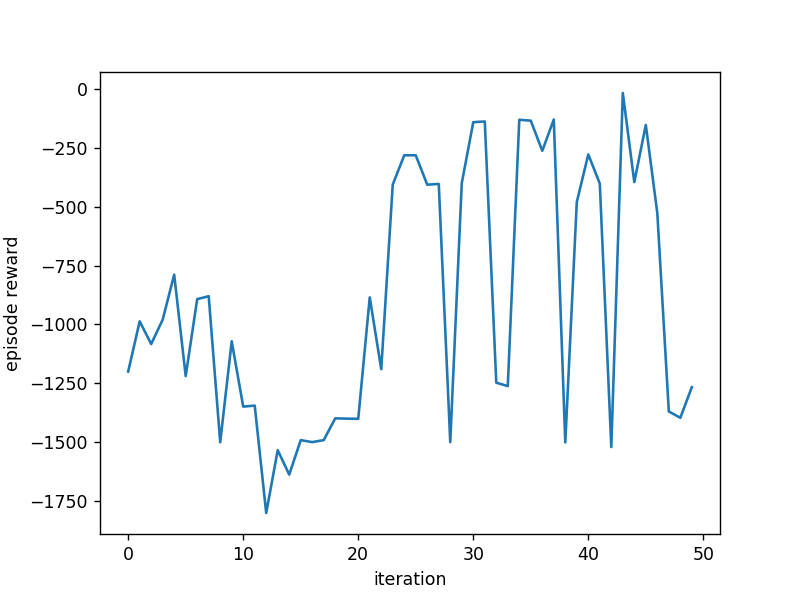

In [34]:
actor_kwargs = {'hidden_sizes' : [32, 64], 'learning_rate' : 0.0001}
critic_kwargs = {'hidden_sizes' : [64, 128], 'learning_rate' : 0.001}
agent = DDPGAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)

# 训练
episodes = 50
episode_rewards = []
chart = Chart()
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
    chart.plot(episode_rewards)

In [35]:
agent.explore = False # 取消探索
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

KeyboardInterrupt: 

### 双重延迟深度确定性策略梯度算法

双重延迟深度确定性策略梯度算法（TD3）结合了深度确定性策略梯度定理和双重Q学习。

双重Q学习可以消除最大偏差。基于查找表的双重Q学习用了两套动作价值函数$q^{(0)},~q^{(1)}$，其中一套动作价值函数用于计算最优动作（如$A' = \mathop{\arg\max}_a q^{(0)}(S',a)$），另外一套价值用来估计回报。双重Q网络则考虑到有了目标网络后已经有了两套价值函数的参数$w$和$w_{目标}$，所以用其中一套参数$w$计算最优动作，再用目标网络的参数$w_{目标}$来估计目标。但是对于确定性策略梯度算法，动作已经由含参策略$\pi(\theta)$决定了，双重网络则要有双重延迟深度确定性策略梯度算法维护两份学习过程的价值网络参数$w^{(i)}$和目标网络参数$w^{(i)}_{目标}$。在估计目标时，选取两个目标网络得到的结果中的较小的那个，即$\min_{i=0,1} q(·,·;w^{(i)}_{目标})$

#### 具体实现

【输入】环境（无数学描述）

【输出】最优策略的估计$\pi(\theta)$

【参数】学习率$\alpha^{(w)},~\alpha^{(\theta)}$，折扣因子$\gamma$，控制回合数和回合内步数的参数，目标网络学习率$\alpha_{目标}$

1. 初始化：$\theta \leftarrow any,~\theta_{目标}\leftarrow any,~w^{(i)} \leftarrow any,~w_{目标}^{(i)} \leftarrow any $
2. 循环执行以下操作：
   1. 累积经验：从起始状态$S$出发，执行以下操作，直至满足条件：
      1. 用对$\pi(S;\theta)$加扰动进而确定动作$A$（如用正态分布随机变量扰动）
      2. 执行$A$，进而得到$S',~R$
      3. 将经验$(S,A,R,S')$存储在经验存储空间$D$
   2. 更新：在更新的时机，执行一次或多次以下操作：
      1. 回放：从存储空间$D$采样出一批经验$B$
      2. 扰动动作：为目标动作$\pi(S';\theta_{目标})$加受限的扰动，得到动作$A'$
      3. 估计回报：$U \leftarrow R +\gamma \min_{i=0,1}q(S',A';w^{(i)})$
      4. 价值更新：更新$w^{(i)}$以减小$\frac{1}{|B|}\sum_{(S,A,R,S' \in B)}[U - q(S,A;w^{(i)})]^2$
      5. 策略更新：更新$\theta$以减小$-\frac{1}{|B|}\sum_{(S,A,R,S' \in B)}q(S,\pi(S;\theta);w^{(0)})$（如$\theta \leftarrow \theta + \alpha^{(\theta)}\frac{1}{|B|}\sum_{(S,A,R,S' \in B)}\nabla\pi(S;\theta)[\nabla_a q(S,a;w^{(0)})]_{a=\pi(S;\theta)}$）
      6. 更新目标：在恰当的时机更新目标网络和目标策略，$w_{目标}^{(i)} = (1-\alpha_{目标})w_{目标}^{(i)} + \alpha_{目标}w^{(i)},~\theta_{目标} = (1-\alpha_{目标})\theta_{目标} + \alpha_{目标}\theta$

In [42]:
class TD3Agent(DDPGAgent):
    def __init__(self, env, actor_kwargs, critic_kwargs,
            replayer_capacity=20000, replayer_initial_transitions=3000,
            gamma=0.99, batches=1, batch_size=64,
            net_learning_rate=0.005, noise_scale=0.1, explore=True):
        observation_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        observation_action_dim = observation_dim + action_dim
        self.action_low = env.action_space.low
        self.action_high = env.action_space.high
        self.gamma = gamma
        self.net_learning_rate = net_learning_rate
        self.explore = explore
        
        self.batches = batches
        self.batch_size = batch_size
        self.replayer = DQNReplayer(replayer_capacity)
        self.replayer_initial_transitions = replayer_initial_transitions
        
        self.noise = OrnsteinUhlenbeckProcess(size=(action_dim,),
                sigma=noise_scale)
        self.noise.reset()
        
        self.actor_evaluate_net = self.build_network(
                input_size=observation_dim, **actor_kwargs)
        self.actor_target_net = self.build_network(
                input_size=observation_dim, **actor_kwargs)
        self.critic0_evaluate_net = self.build_network(
                input_size=observation_action_dim, **critic_kwargs)
        self.critic0_target_net = self.build_network(
                input_size=observation_action_dim, **critic_kwargs)
        self.critic1_evaluate_net = self.build_network(
                input_size=observation_action_dim, **critic_kwargs)
        self.critic1_target_net = self.build_network(
                input_size=observation_action_dim, **critic_kwargs)
        
        self.update_target_net(self.actor_target_net,
                self.actor_evaluate_net)
        self.update_target_net(self.critic0_target_net,
                self.critic0_evaluate_net)
        self.update_target_net(self.critic1_target_net,
                self.critic1_evaluate_net)
        
    def learn(self, state, action, reward, next_state, done):
        self.replayer.store(state, action, reward, next_state, done)
        
        if self.replayer.count >= self.replayer_initial_transitions:
            if done:
                self.noise.reset()
                
            for batch in range(self.batches):
                states, actions, rewards, next_states, dones = \
                    self.replayer.sample(self.batch_size)
                
                # train Actor
                state_tensor = tf.convert_to_tensor(states, dtype = tf.float32)
                with tf.GradientTape() as tape:
                    action_tensor = self.actor_evaluate_net(state_tensor)
                    input_tensor = tf.concat([state_tensor, action_tensor], axis = 1)
                    q_tensor = self.critic0_evaluate_net(input_tensor)
                    loss_tensor = -tf.reduce_mean(q_tensor)
                grads = tape.gradient(loss_tensor, self.actor_evaluate_net.variables)
                self.actor_evaluate_net.optimizer.apply_gradients(zip(
                    grads, self.actor_evaluate_net.variables))
                
                # train Critic
                next_actions = self.actor_target_net.predict(next_states)
                state_actions = np.hstack([states, actions])
                next_state_actions = np.hstack([next_states, next_actions])
                next_q0s = self.critic0_target_net.predict(next_state_actions)[:, 0]
                next_q1s = self.critic1_target_net.predict(next_state_actions)[:, 0]
                next_qs = np.minimum(next_q0s, next_q1s)
                targets = rewards + self.gamma * (1 - dones) * next_qs
                self.critic0_evaluate_net.fit(state_actions,
                        targets[:, np.newaxis], verbose=0)
                self.critic1_evaluate_net.fit(state_actions,
                        targets[:, np.newaxis], verbose=0)
                
                self.update_target_net(self.actor_target_net,
                        self.actor_evaluate_net, self.net_learning_rate)
                self.update_target_net(self.critic0_target_net,
                        self.critic0_evaluate_net, self.net_learning_rate)
                self.update_target_net(self.critic1_target_net,
                        self.critic1_evaluate_net, self.net_learning_rate)

<IPython.core.display.Javascript object>


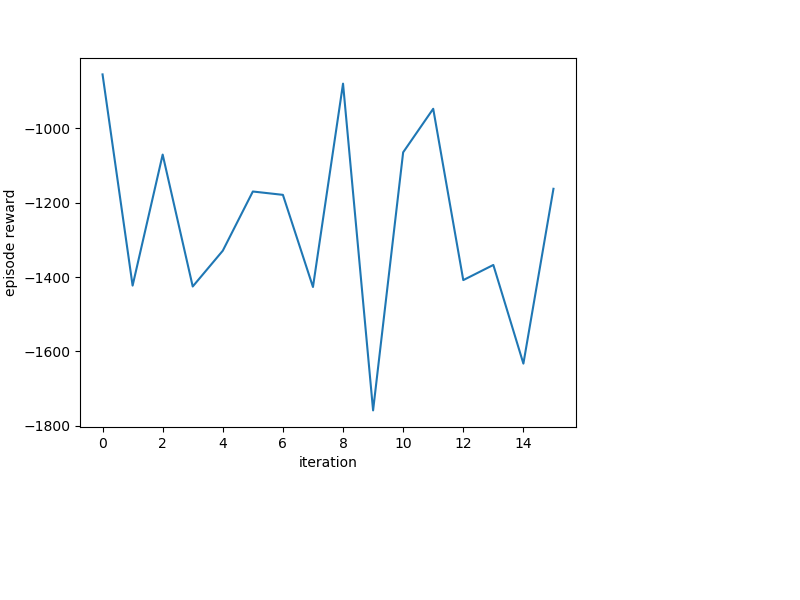

In [ ]:
actor_kwargs = {'hidden_sizes' : [32, 64], 'learning_rate' : 0.0001}
critic_kwargs = {'hidden_sizes' : [64, 128], 'learning_rate' : 0.001}
agent = TD3Agent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)

# 训练
episodes = 50
episode_rewards = []
chart = Chart()
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
    chart.plot(episode_rewards)